In [1]:
from datasets import Dataset
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline, TrainingArguments, logging
from tqdm import tqdm
logging.set_verbosity_error()
from peft import LoraConfig, PeftConfig, PeftModel
from trl import SFTTrainer
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    balanced_accuracy_score
)
import numpy as np
import os
import sys
import gc
milestone_2_path = os.path.abspath("../milestone 2")
sys.path.append(milestone_2_path)

import import_preprocess
from importlib import reload
reload(import_preprocess)

from import_preprocess import ImportPreprocess, convert_labels_to_string, convert_labels_to_int

2025-01-25 21:22:34.662521: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-25 21:22:34.662592: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-25 21:22:34.684384: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-25 21:22:34.735234: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-25 21:22:35.608600: W tensorflow/compiler/tf2

# Load data

In [2]:
import_preprocess = ImportPreprocess()
import_preprocess.import_train_val_test()
import_preprocess.create_balanced_dataset(n_samples=7000)

_, y_train, S_train, y_train_multi = import_preprocess.X_train, import_preprocess.y_train, import_preprocess.S_train, import_preprocess.y_train_multi
_, y_val, S_val, y_val_multi = import_preprocess.X_val, import_preprocess.y_val, import_preprocess.S_val, import_preprocess.y_val_multi
_, y_test, S_test, y_test_multi = import_preprocess.X_test, import_preprocess.y_test, import_preprocess.S_test, import_preprocess.y_test_multi
_, y_balanced, S_balanced, y_balanced_multi = import_preprocess.X_train_balanced, import_preprocess.y_train_balanced, import_preprocess.S_train_balanced, import_preprocess.y_train_multi_balanced

print("Number of training samples:", len(y_train))
print("Number of validation samples:", len(y_val))
print("Number of test samples:", len(y_test))
print("Number of balanced samples:", len(y_balanced))

train_df = pd.DataFrame({"comment": S_train, "label": y_train, "multi_label": y_train_multi})
val_df = pd.DataFrame({"comment": S_val, "label": y_val, "multi_label": y_val_multi})
test_df = pd.DataFrame({"comment": S_test, "label": y_test, "multi_label": y_test_multi})
balanced_df = pd.DataFrame({"comment": S_balanced, "label": y_balanced, "multi_label": y_balanced_multi})

def generate_prompt(entry):
    return f"""
Classify the text into "sexist" or "not sexist", and return the answer as the corresponding label.
text: {entry["comment"]}
label: {entry["label"]}
""".strip()

def generate_test_prompt(entry):
    return f"""
Classify the text into "sexist" or "not sexist", and return the answer as the corresponding label.
text: {entry["comment"]}
label:
""".strip()

train_df["text"] = train_df.apply(generate_prompt, axis=1)
val_df["text"] = val_df.apply(generate_prompt, axis=1)
balanced_df["text"] = balanced_df.apply(generate_prompt, axis=1)
test_df["text"] = test_df.apply(generate_test_prompt, axis=1)

train_data = Dataset.from_pandas(train_df)
val_data = Dataset.from_pandas(val_df)
balanced_data = Dataset.from_pandas(balanced_df)
test_data = Dataset.from_pandas(test_df)

Number of training samples: 14000
Number of validation samples: 2000
Number of test samples: 4000
Number of balanced samples: 14000


# Evaluate model without fine-tuning

In [3]:
def clear_memory():
    try:
        global model
        global tokenizer
        del model, tokenizer
    except NameError:
        pass
    finally:
        gc.collect()
        torch.cuda.empty_cache()

In [4]:
clear_memory()

model_id = "microsoft/phi-4"
tokenizer = AutoTokenizer.from_pretrained(model_id)

model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="cuda:0",
    load_in_8bit=True,
)

model.config.use_cache = False
tokenizer.pad_token_id = tokenizer.eos_token_id

Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

In [4]:
def predict(test_data, model, tokenizer, categories, temperature=0.01):
    y_pred = []
    categories = categories

    for i in tqdm(range(len(test_data))):
        prompt = test_data[i]["text"]

        pipe = pipeline(
            task="text-generation",
            model=model,
            tokenizer=tokenizer,
            max_new_tokens=2,
            temperature=temperature
        )
        result = pipe(prompt)
        answer = result[0]['generated_text'].split("label:")[-1].strip()

        for category in categories:
            if category == answer.lower():
                y_pred.append(category)
                break
        else:
            y_pred.append("none")

    return y_pred


def evaluate(y_true, y_pred):
    labels = ["not sexist", "sexist", "none"]
    mapping = {label: idx for idx, label in enumerate(labels)}

    def map_func(x):
        return mapping.get(x, -1)

    y_true_mapped = np.vectorize(map_func)(y_true)
    y_pred_mapped = np.vectorize(map_func)(y_pred)

    accuracy = accuracy_score(y_true=y_true_mapped, y_pred=y_pred_mapped)
    print(f'Accuracy: {accuracy:.3f}')

    balanced_accuracy = balanced_accuracy_score(y_true=y_true_mapped, y_pred=y_pred_mapped)
    print(f'Balanced Accuracy: {balanced_accuracy:.3f}')

    class_report = classification_report(y_true=y_true_mapped, y_pred=y_pred_mapped, target_names=labels, labels=list(range(len(labels))), zero_division=0, digits=3)
    print('\nClassification Report:')
    print(class_report)

    conf_matrix = confusion_matrix(y_true=y_true_mapped, y_pred=y_pred_mapped, labels=list(range(len(labels))))
    print('\nConfusion Matrix:')
    print(conf_matrix)

In [6]:
val_df["text"] = val_df.apply(generate_test_prompt, axis=1)
val_data = Dataset.from_pandas(val_df)

y_pred = predict(val_data, model, tokenizer, ["not sexist", "sexist"])
evaluate(y_val, y_pred)

val_df["text"] = val_df.apply(generate_prompt, axis=1)
val_data = Dataset.from_pandas(val_df)

  0%|          | 0/2000 [00:00<?, ?it/s]/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.01` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
100%|██████████| 2000/2000 [03:13<00:00, 10.31it/s]

Accuracy: 0.086
Balanced Accuracy: 0.141

Classification Report:
              precision    recall  f1-score   support

  not sexist      0.980     0.033     0.064      1514
      sexist      0.318     0.249     0.279       486
        none      0.000     0.000     0.000         0

    accuracy                          0.086      2000
   macro avg      0.433     0.094     0.114      2000
weighted avg      0.820     0.086     0.116      2000


Confusion Matrix:
[[  50  259 1205]
 [   1  121  364]
 [   0    0    0]]



/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


# Define functions for fine-tuning

In [5]:
def find_all_linear_names(model):
    cls = torch.nn.Linear
    lora_module_names = set()
    for name, module in model.named_modules():
        if isinstance(module, cls):
            names = name.split('.')
            lora_module_names.add(names[0] if len(names) == 1 else names[-1])
    if 'lm_head' in lora_module_names:
        lora_module_names.remove('lm_head')
    return list(lora_module_names)


def fine_tune(model, tokenizer, train_dataset, eval_dataset, fine_tuned_dir, new_model_dir, epochs):
    modules = find_all_linear_names(model)

    peft_config = LoraConfig(
        lora_alpha=16,
        lora_dropout=0,
        r=64,
        bias="none",
        task_type="CAUSAL_LM",
        target_modules=modules,
    )

    training_arguments = TrainingArguments(
        output_dir=fine_tuned_dir,
        num_train_epochs=epochs,
        per_device_train_batch_size=2,
        gradient_accumulation_steps=4,
        gradient_checkpointing=True,
        optim="paged_adamw_32bit",
        logging_steps=1,
        learning_rate=2e-4,
        weight_decay=0.001,
        fp16=True,
        bf16=False,
        max_grad_norm=0.3,
        max_steps=-1,
        warmup_ratio=0.03,
        group_by_length=False,
        lr_scheduler_type="cosine",
        eval_strategy="epoch",
        report_to=["tensorboard"],
        save_strategy="epoch",
    )

    trainer = SFTTrainer(
        model=model,
        args=training_arguments,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        peft_config=peft_config,
        tokenizer=tokenizer,
    )

    trainer.train()

    trainer.save_model(fine_tuned_dir)
    tokenizer.save_pretrained(fine_tuned_dir)

    model = PeftModel.from_pretrained(model, fine_tuned_dir)
    model = model.merge_and_unload()

    model.save_pretrained(new_model_dir)
    tokenizer.save_pretrained(new_model_dir)

    del trainer

    return model, tokenizer

# Fine-tune model on train set

In [8]:
model_id = "microsoft/phi-4"
output_dir_base = "phi-4-fine-tuned-train"
new_model_dir_base = "phi-4-Sexism-Classification-Train"

epochs = 2
clear_memory()
output_dir = f"{output_dir_base}-{epochs}"
new_model_dir = f"{new_model_dir_base}-{epochs}"

tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="cuda:0",
    load_in_8bit=True
)
model.config.use_cache = False
tokenizer.pad_token_id = tokenizer.eos_token_id

model, tokenizer = fine_tune(model, tokenizer, train_data, val_data, output_dir, new_model_dir, epochs)

Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

/tmp/ipykernel_57844/524768575.py:47: FutureWarning: `tokenizer` is deprecated and removed starting from version 0.16.0 for `SFTTrainer.__init__`. Use `processing_class` instead.
  trainer = SFTTrainer(


Map:   0%|          | 0/14000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


{'loss': 14.7888, 'grad_norm': 1.6513041257858276, 'learning_rate': 1.9047619047619051e-06, 'epoch': 0.0005714285714285715}
{'loss': 13.798, 'grad_norm': 1.7017605304718018, 'learning_rate': 3.8095238095238102e-06, 'epoch': 0.001142857142857143}
{'loss': 13.2002, 'grad_norm': 1.4500137567520142, 'learning_rate': 5.7142857142857145e-06, 'epoch': 0.0017142857142857142}
{'loss': 14.136, 'grad_norm': 1.4948625564575195, 'learning_rate': 7.6190476190476205e-06, 'epoch': 0.002285714285714286}
{'loss': 13.9692, 'grad_norm': 1.6018307209014893, 'learning_rate': 9.523809523809523e-06, 'epoch': 0.002857142857142857}
{'loss': 13.7023, 'grad_norm': 1.6479741334915161, 'learning_rate': 1.1428571428571429e-05, 'epoch': 0.0034285714285714284}
{'loss': 13.0779, 'grad_norm': 1.5779361724853516, 'learning_rate': 1.3333333333333333e-05, 'epoch': 0.004}
{'loss': 13.8329, 'grad_norm': 1.8199199438095093, 'learning_rate': 1.5238095238095241e-05, 'epoch': 0.004571428571428572}
{'loss': 14.2721, 'grad_norm': 

/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/peft/utils/other.py:716: UserWarning: Unable to fetch remote file due to the following error (ProtocolError('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')), '(Request ID: 211b15ed-7c3b-42a1-aee1-070a9beae413)') - silently ignoring the lookup for the file config.json in microsoft/phi-4.
  warnings.warn(
/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/peft/utils/save_and_load.py:246: UserWarning: Could not find a config file in microsoft/phi-4 - will assume that the vocabulary was not modified.
  warnings.warn(
/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use

{'loss': 6.9385, 'grad_norm': 0.5871276259422302, 'learning_rate': 0.00010476379345696943, 'epoch': 1.0005714285714287}
{'loss': 6.9767, 'grad_norm': 0.607835054397583, 'learning_rate': 0.00010467136062331207, 'epoch': 1.0011428571428571}
{'loss': 6.8032, 'grad_norm': 0.5807561874389648, 'learning_rate': 0.00010457892378962188, 'epoch': 1.0017142857142858}
{'loss': 6.754, 'grad_norm': 0.6075104475021362, 'learning_rate': 0.00010448648303505151, 'epoch': 1.0022857142857142}
{'loss': 6.7008, 'grad_norm': 0.6253503561019897, 'learning_rate': 0.0001043940384387569, 'epoch': 1.002857142857143}
{'loss': 6.792, 'grad_norm': 0.8492748737335205, 'learning_rate': 0.0001043015900798973, 'epoch': 1.0034285714285713}
{'loss': 6.8913, 'grad_norm': 0.6452019810676575, 'learning_rate': 0.00010420913803763521, 'epoch': 1.004}
{'loss': 7.7186, 'grad_norm': 0.655214786529541, 'learning_rate': 0.00010411668239113624, 'epoch': 1.0045714285714287}
{'loss': 6.6924, 'grad_norm': 0.6267065405845642, 'learning_

/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


{'eval_loss': 1.8265602588653564, 'eval_runtime': 43.6541, 'eval_samples_per_second': 45.815, 'eval_steps_per_second': 5.727, 'epoch': 2.0}
{'train_runtime': 9054.6709, 'train_samples_per_second': 3.092, 'train_steps_per_second': 0.387, 'train_loss': 6.70896949509212, 'epoch': 2.0}


/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/peft/tuners/lora/bnb.py:85: UserWarning: Merge lora module to 8-bit linear may get different generations due to rounding errors.
  warnings.warn(


OutOfMemoryError: CUDA out of memory. Tried to allocate 700.00 MiB. GPU 0 has a total capacity of 23.64 GiB of which 157.69 MiB is free. Including non-PyTorch memory, this process has 21.51 GiB memory in use. Of the allocated memory 19.77 GiB is allocated by PyTorch, and 1.28 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

# Fine-tune model on balanced data set

In [6]:
model_id = "microsoft/phi-4"
output_dir_base = "phi-4-fine-tuned-balanced"
new_model_dir_base = "phi-4-Sexism-Classification-Balanced"

epochs = 2
clear_memory()
output_dir = f"{output_dir_base}-{epochs}"
new_model_dir = f"{new_model_dir_base}-{epochs}"

tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="cuda:0",
    load_in_8bit=True
)
model.config.use_cache = False
tokenizer.pad_token_id = tokenizer.eos_token_id

model, tokenizer = fine_tune(model, tokenizer, balanced_data, val_data, output_dir, new_model_dir, epochs)

Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

/tmp/ipykernel_85979/524768575.py:47: FutureWarning: `tokenizer` is deprecated and removed starting from version 0.16.0 for `SFTTrainer.__init__`. Use `processing_class` instead.
  trainer = SFTTrainer(


Map:   0%|          | 0/14000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


{'loss': 13.8108, 'grad_norm': 1.6365420818328857, 'learning_rate': 1.9047619047619051e-06, 'epoch': 0.0005714285714285715}
{'loss': 13.8529, 'grad_norm': 1.7824712991714478, 'learning_rate': 3.8095238095238102e-06, 'epoch': 0.001142857142857143}
{'loss': 13.9722, 'grad_norm': 1.264914870262146, 'learning_rate': 5.7142857142857145e-06, 'epoch': 0.0017142857142857142}
{'loss': 13.0862, 'grad_norm': 1.703548789024353, 'learning_rate': 7.6190476190476205e-06, 'epoch': 0.002285714285714286}
{'loss': 13.6424, 'grad_norm': 1.6365469694137573, 'learning_rate': 9.523809523809523e-06, 'epoch': 0.002857142857142857}
{'loss': 13.5725, 'grad_norm': 1.6010816097259521, 'learning_rate': 1.1428571428571429e-05, 'epoch': 0.0034285714285714284}
{'loss': 13.6209, 'grad_norm': 1.5402346849441528, 'learning_rate': 1.3333333333333333e-05, 'epoch': 0.004}
{'loss': 13.6414, 'grad_norm': 1.7293914556503296, 'learning_rate': 1.5238095238095241e-05, 'epoch': 0.004571428571428572}
{'loss': 13.2452, 'grad_norm': 

/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/peft/utils/other.py:716: UserWarning: Unable to fetch remote file due to the following error (ProtocolError('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')), '(Request ID: 8cb4e8b8-27e3-4068-b943-1688f36c5d9f)') - silently ignoring the lookup for the file config.json in microsoft/phi-4.
  warnings.warn(
/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/peft/utils/save_and_load.py:246: UserWarning: Could not find a config file in microsoft/phi-4 - will assume that the vocabulary was not modified.
  warnings.warn(
/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use

{'loss': 3.8834, 'grad_norm': 1.678238868713379, 'learning_rate': 0.00010485622221144484, 'epoch': 1.0005714285714287}
{'loss': 5.5312, 'grad_norm': 1.425613284111023, 'learning_rate': 0.00010476379345696943, 'epoch': 1.0011428571428571}
{'loss': 5.1314, 'grad_norm': 1.2018380165100098, 'learning_rate': 0.00010467136062331207, 'epoch': 1.0017142857142858}
{'loss': 4.8992, 'grad_norm': 1.8276828527450562, 'learning_rate': 0.00010457892378962188, 'epoch': 1.0022857142857142}
{'loss': 6.3382, 'grad_norm': 1.4211682081222534, 'learning_rate': 0.00010448648303505151, 'epoch': 1.002857142857143}
{'loss': 4.6196, 'grad_norm': 2.1009650230407715, 'learning_rate': 0.0001043940384387569, 'epoch': 1.0034285714285713}
{'loss': 4.1791, 'grad_norm': 1.2735475301742554, 'learning_rate': 0.0001043015900798973, 'epoch': 1.004}
{'loss': 5.1874, 'grad_norm': 2.237474203109741, 'learning_rate': 0.00010420913803763521, 'epoch': 1.0045714285714287}
{'loss': 5.865, 'grad_norm': 1.8733367919921875, 'learning_

/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


{'eval_loss': 1.9643734693527222, 'eval_runtime': 42.2036, 'eval_samples_per_second': 47.389, 'eval_steps_per_second': 5.924, 'epoch': 2.0}
{'train_runtime': 8790.6942, 'train_samples_per_second': 3.185, 'train_steps_per_second': 0.398, 'train_loss': 5.609372314044408, 'epoch': 2.0}


/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/peft/tuners/lora/bnb.py:85: UserWarning: Merge lora module to 8-bit linear may get different generations due to rounding errors.
  warnings.warn(


OutOfMemoryError: CUDA out of memory. Tried to allocate 700.00 MiB. GPU 0 has a total capacity of 23.64 GiB of which 258.25 MiB is free. Including non-PyTorch memory, this process has 21.64 GiB memory in use. Of the allocated memory 19.75 GiB is allocated by PyTorch, and 1.42 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

# Benchmarking models

## Benchmarking model fine-tuned on train set

In [5]:
val_df["text"] = val_df.apply(generate_test_prompt, axis=1)
val_data = Dataset.from_pandas(val_df)

clear_memory()

model_id = "microsoft/phi-4"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="cuda:0",
    load_in_8bit=True
)
model.config.use_cache = False
tokenizer.pad_token_id = tokenizer.eos_token_id

fine_tuned_dir = "phi-4-fine-tuned-train-2"

for i in range(1, 3):
    checkpoint_dir = f"{fine_tuned_dir}/checkpoint-{i*1750}"
    model = PeftModel.from_pretrained(model, checkpoint_dir)
    model = model.merge_and_unload()

    y_pred = predict(val_data, model, tokenizer, ["not sexist", "sexist"])
    print(f"\n ------------------ Checkpoint {i} ------------------ ")
    evaluate(y_val, y_pred)
    print(" ----------------------------------------------------- \n")

Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/peft/tuners/lora/bnb.py:85: UserWarning: Merge lora module to 8-bit linear may get different generations due to rounding errors.
  warnings.warn(
  0%|          | 0/2000 [00:00<?, ?it/s]/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.01` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
100%|██████████| 2000/2000 [05:47<00:00,  5.75it/s]



 ------------------ Checkpoint 1 ------------------ 
Accuracy: 0.901
Balanced Accuracy: 0.869

Classification Report:
              precision    recall  f1-score   support

  not sexist      0.938     0.932     0.935      1514
      sexist      0.792     0.807     0.799       486
        none      0.000     0.000     0.000         0

    accuracy                          0.901      2000
   macro avg      0.576     0.580     0.578      2000
weighted avg      0.902     0.901     0.902      2000


Confusion Matrix:
[[1411  103    0]
 [  94  392    0]
 [   0    0    0]]
 ----------------------------------------------------- 



/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/peft/tuners/lora/bnb.py:85: UserWarning: Merge lora module to 8-bit linear may get different generations due to rounding errors.
  warnings.warn(
  0%|          | 0/2000 [00:00<?, ?it/s]/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.01` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
100%|██████████| 2000/2000 [05:54<00:00,  5.65it/s]


 ------------------ Checkpoint 2 ------------------ 
Accuracy: 0.888
Balanced Accuracy: 0.863

Classification Report:
              precision    recall  f1-score   support

  not sexist      0.939     0.911     0.925      1514
      sexist      0.757     0.815     0.785       486
        none      0.000     0.000     0.000         0

    accuracy                          0.888      2000
   macro avg      0.565     0.575     0.570      2000
weighted avg      0.895     0.888     0.891      2000


Confusion Matrix:
[[1380  127    7]
 [  90  396    0]
 [   0    0    0]]
 ----------------------------------------------------- 




/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


## Benchmarking model fine-tuned on balanced set

In [6]:
val_df["text"] = val_df.apply(generate_test_prompt, axis=1)
val_data = Dataset.from_pandas(val_df)

clear_memory()

model_id = "microsoft/phi-4"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="cuda:0",
    load_in_8bit=True
)
model.config.use_cache = False
tokenizer.pad_token_id = tokenizer.eos_token_id

fine_tuned_dir = "phi-4-fine-tuned-balanced-2"

for i in range(1, 3):
    checkpoint_dir = f"{fine_tuned_dir}/checkpoint-{i*1750}"
    model = PeftModel.from_pretrained(model, checkpoint_dir)
    model = model.merge_and_unload()

    y_pred = predict(val_data, model, tokenizer, ["not sexist", "sexist"])
    print(f"\n ------------------ Checkpoint {i} ------------------ ")
    evaluate(y_val, y_pred)
    print(" ----------------------------------------------------- \n")

Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/peft/tuners/lora/bnb.py:85: UserWarning: Merge lora module to 8-bit linear may get different generations due to rounding errors.
  warnings.warn(
  0%|          | 0/2000 [00:00<?, ?it/s]/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.01` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
100%|██████████| 2000/2000 [05:54<00:00,  5.65it/s]



 ------------------ Checkpoint 1 ------------------ 
Accuracy: 0.897
Balanced Accuracy: 0.868

Classification Report:
              precision    recall  f1-score   support

  not sexist      0.938     0.925     0.931      1514
      sexist      0.776     0.811     0.793       486
        none      0.000     0.000     0.000         0

    accuracy                          0.897      2000
   macro avg      0.571     0.578     0.575      2000
weighted avg      0.899     0.897     0.898      2000


Confusion Matrix:
[[1400  114    0]
 [  92  394    0]
 [   0    0    0]]
 ----------------------------------------------------- 



/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/peft/tuners/lora/bnb.py:85: UserWarning: Merge lora module to 8-bit linear may get different generations due to rounding errors.
  warnings.warn(
  0%|          | 0/2000 [00:00<?, ?it/s]/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.01` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
100%|██████████| 2000/2000 [06:09<00:00,  5.41it/s]


 ------------------ Checkpoint 2 ------------------ 
Accuracy: 0.882
Balanced Accuracy: 0.851

Classification Report:
              precision    recall  f1-score   support

  not sexist      0.931     0.911     0.921      1514
      sexist      0.741     0.790     0.765       486
        none      0.000     0.000     0.000         0

    accuracy                          0.882      2000
   macro avg      0.557     0.567     0.562      2000
weighted avg      0.885     0.882     0.883      2000


Confusion Matrix:
[[1380  134    0]
 [ 102  384    0]
 [   0    0    0]]
 ----------------------------------------------------- 



# Trying to explain predictions

## Load best model and evaluate on test set

In [7]:
clear_memory()

model_id = "microsoft/phi-4"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="cuda:0",
    load_in_8bit=True
)
model.config.use_cache = False
tokenizer.pad_token_id = tokenizer.eos_token_id

checkpoint_dir = "phi-4-fine-tuned-train-2/checkpoint-1750"

model = PeftModel.from_pretrained(model, checkpoint_dir)
model = model.merge_and_unload()

y_pred = predict(test_data, model, tokenizer, ["not sexist", "sexist"])
evaluate(y_test, y_pred)

Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/peft/tuners/lora/bnb.py:85: UserWarning: Merge lora module to 8-bit linear may get different generations due to rounding errors.
  warnings.warn(
  0%|          | 0/4000 [00:00<?, ?it/s]/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.01` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
100%|██████████| 4000/4000 [11:26<00:00,  5.83it/s]

Accuracy: 0.893
Balanced Accuracy: 0.865

Classification Report:
              precision    recall  f1-score   support

  not sexist      0.938     0.920     0.929      3030
      sexist      0.765     0.809     0.787       970
        none      0.000     0.000     0.000         0

    accuracy                          0.893      4000
   macro avg      0.568     0.577     0.572      4000
weighted avg      0.896     0.893     0.894      4000


Confusion Matrix:
[[2789  241    0]
 [ 185  785    0]
 [   0    0    0]]


In [8]:
def get_next_token_probabilities(prompt, model, tokenizer):
    inputs = tokenizer(prompt, return_tensors="pt").to("cuda:0")

    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    next_token_logits = logits[:, -1, :]

    probabilities = torch.softmax(next_token_logits, dim=-1)

    top_k = 5
    top_k_probs, top_k_token_ids = torch.topk(probabilities, k=top_k, dim=-1)

    top_k_tokens = [tokenizer.decode(token_id) for token_id in top_k_token_ids[0]]

    print(f"Next top-{top_k} Tokens and Probabilities:")
    for token, prob in zip(top_k_tokens, top_k_probs[0]):
        if token.strip():
            print(f"Token: '{token}', Probability: {prob.item()*100:.2f}%")
        else:
            print(f"Token: '{repr(token)}', Probability: {prob.item()*100:.2f}%")

def generate_answer(prompt, model, tokenizer, max_new_tokens=2, temperature=0.01):
    pipe = pipeline(
        task="text-generation",
        model=model,
        tokenizer=tokenizer,
        max_new_tokens=max_new_tokens,
        temperature=temperature
    )
    result = pipe(prompt)
    return result[0]['generated_text']

prompt = generate_test_prompt({"comment": "I hate women", "label": "not sexist"})

print(f"Prompt:\n{prompt}\n")
get_next_token_probabilities(prompt, model, tokenizer)
print(f"\nAnswer:\n{(generate_answer(prompt, model, tokenizer))}")

/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.01` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


Prompt:
Classify the text into "sexist" or "not sexist", and return the answer as the corresponding label.
text: I hate women
label:

Next top-5 Tokens and Probabilities:
Token: ' sexist', Probability: 95.07%
Token: ' not', Probability: 4.88%
Token: ' misogyn', Probability: 0.03%
Token: ' "', Probability: 0.00%
Token: ' Not', Probability: 0.00%

Answer:
Classify the text into "sexist" or "not sexist", and return the answer as the corresponding label.
text: I hate women
label: sexist



In [9]:
prompt = generate_test_prompt({"comment": "I think women belong in the kitchen"})
print(f"\nAnswer:\n{(generate_answer(prompt, model, tokenizer))}")
prompt = generate_test_prompt({"comment": "I don’t think women belong in the kitchen"})
print(f"\nAnswer:\n{(generate_answer(prompt, model, tokenizer))}")
prompt = generate_test_prompt({"comment": "I think forks belong in the kitchen"})
print(f"\nAnswer:\n{(generate_answer(prompt, model, tokenizer))}")
prompt = generate_test_prompt({"comment": "I don’t think forks belong in the kitchen"})
print(f"\nAnswer:\n{(generate_answer(prompt, model, tokenizer))}")
prompt = generate_test_prompt({"comment": "Women should have the right to vote"})
print(f"\nAnswer:\n{(generate_answer(prompt, model, tokenizer))}")
prompt = generate_test_prompt({"comment": "Women shouldn’t have the right to vote"})
print(f"\nAnswer:\n{(generate_answer(prompt, model, tokenizer))}")


Answer:
Classify the text into "sexist" or "not sexist", and return the answer as the corresponding label.
text: I think women belong in the kitchen
label: sexist


Answer:
Classify the text into "sexist" or "not sexist", and return the answer as the corresponding label.
text: I don’t think women belong in the kitchen
label: sexist


Answer:
Classify the text into "sexist" or "not sexist", and return the answer as the corresponding label.
text: I think forks belong in the kitchen
label: not sexist

Answer:
Classify the text into "sexist" or "not sexist", and return the answer as the corresponding label.
text: I don’t think forks belong in the kitchen
label: not sexist

Answer:
Classify the text into "sexist" or "not sexist", and return the answer as the corresponding label.
text: Women should have the right to vote
label: not sexist

Answer:
Classify the text into "sexist" or "not sexist", and return the answer as the corresponding label.
text: Women shouldn’t have the right to vote
l

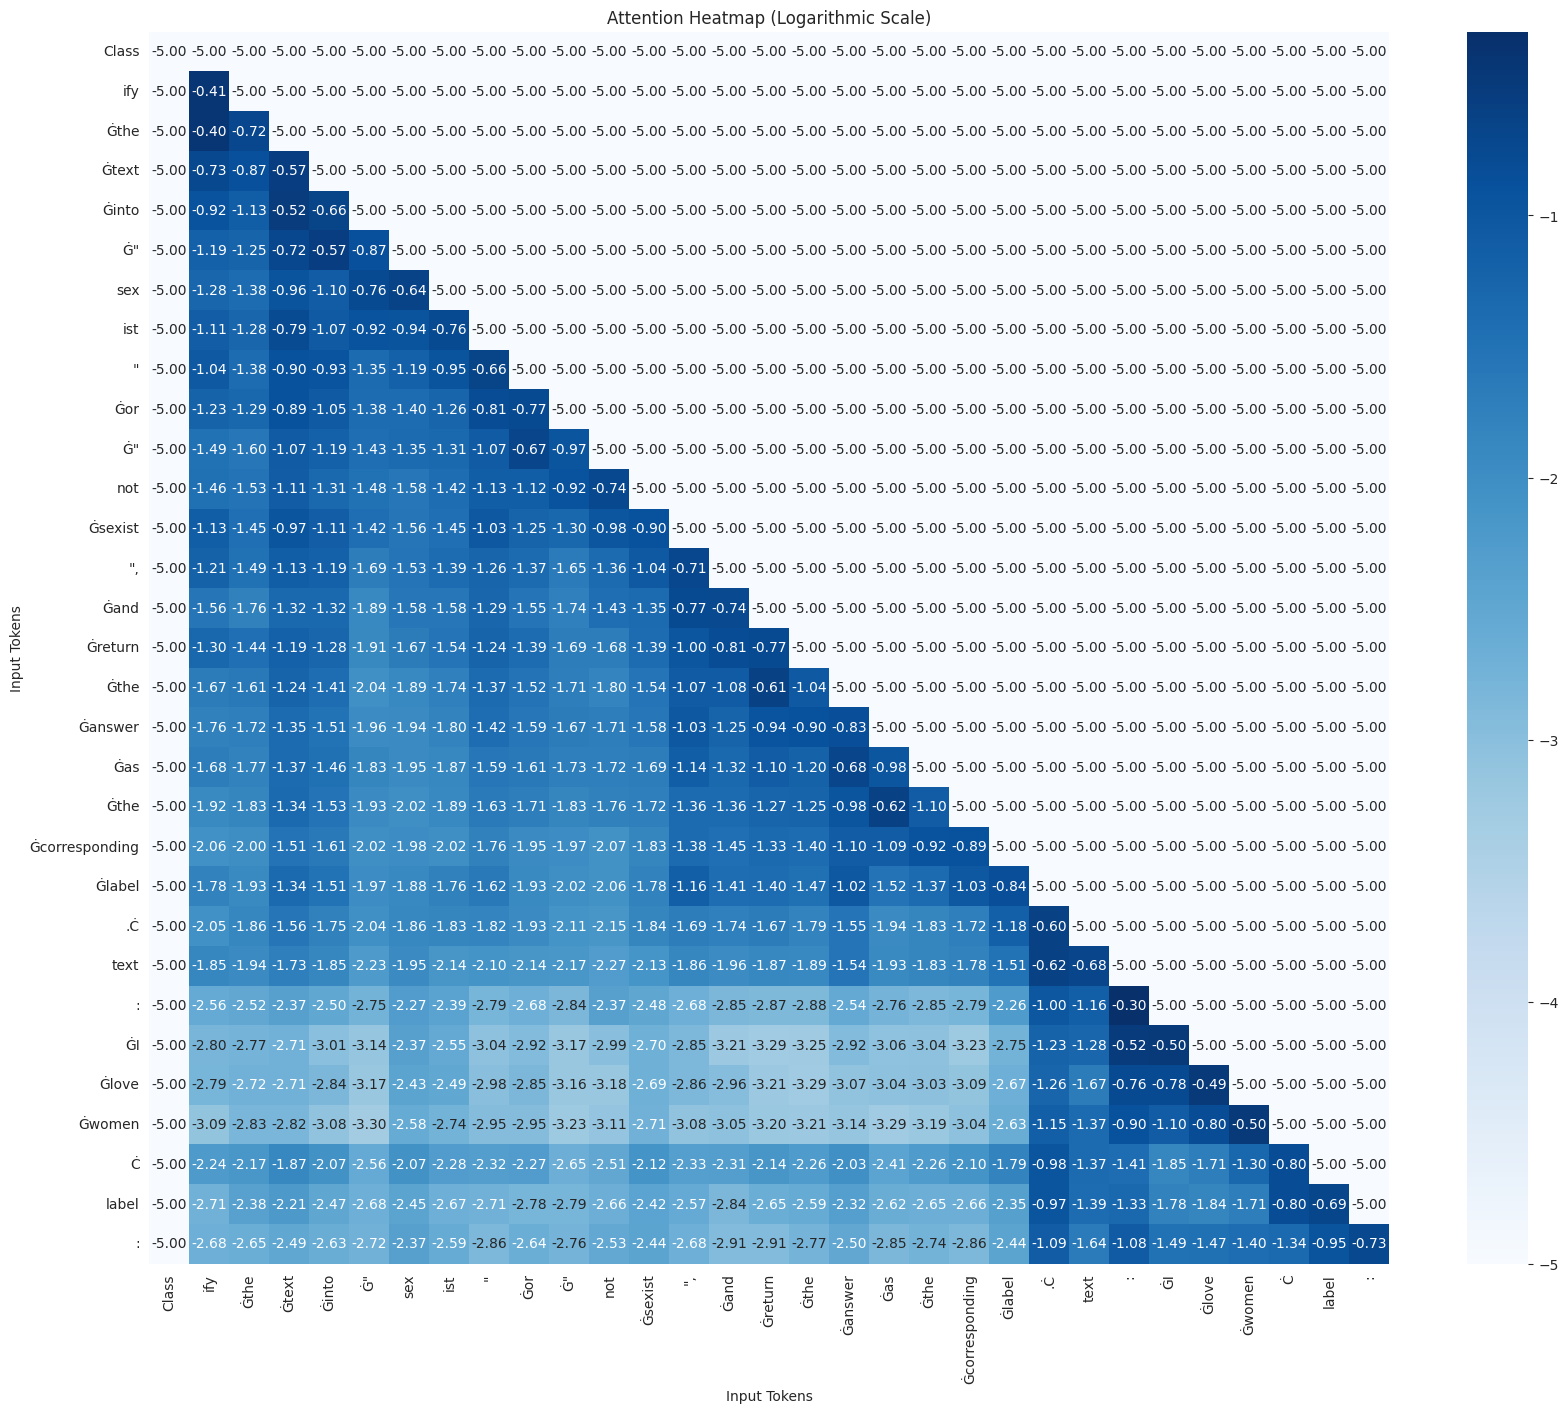

/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.01` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


Classify the text into "sexist" or "not sexist", and return the answer as the corresponding label.
text: I love women
label: not sexist 

Next top-5 Tokens and Probabilities:
Token: ' not', Probability: 99.32%
Token: ' sexist', Probability: 0.66%
Token: ' Not', Probability: 0.00%
Token: ' neutral', Probability: 0.00%
Token: ' feminist', Probability: 0.00%


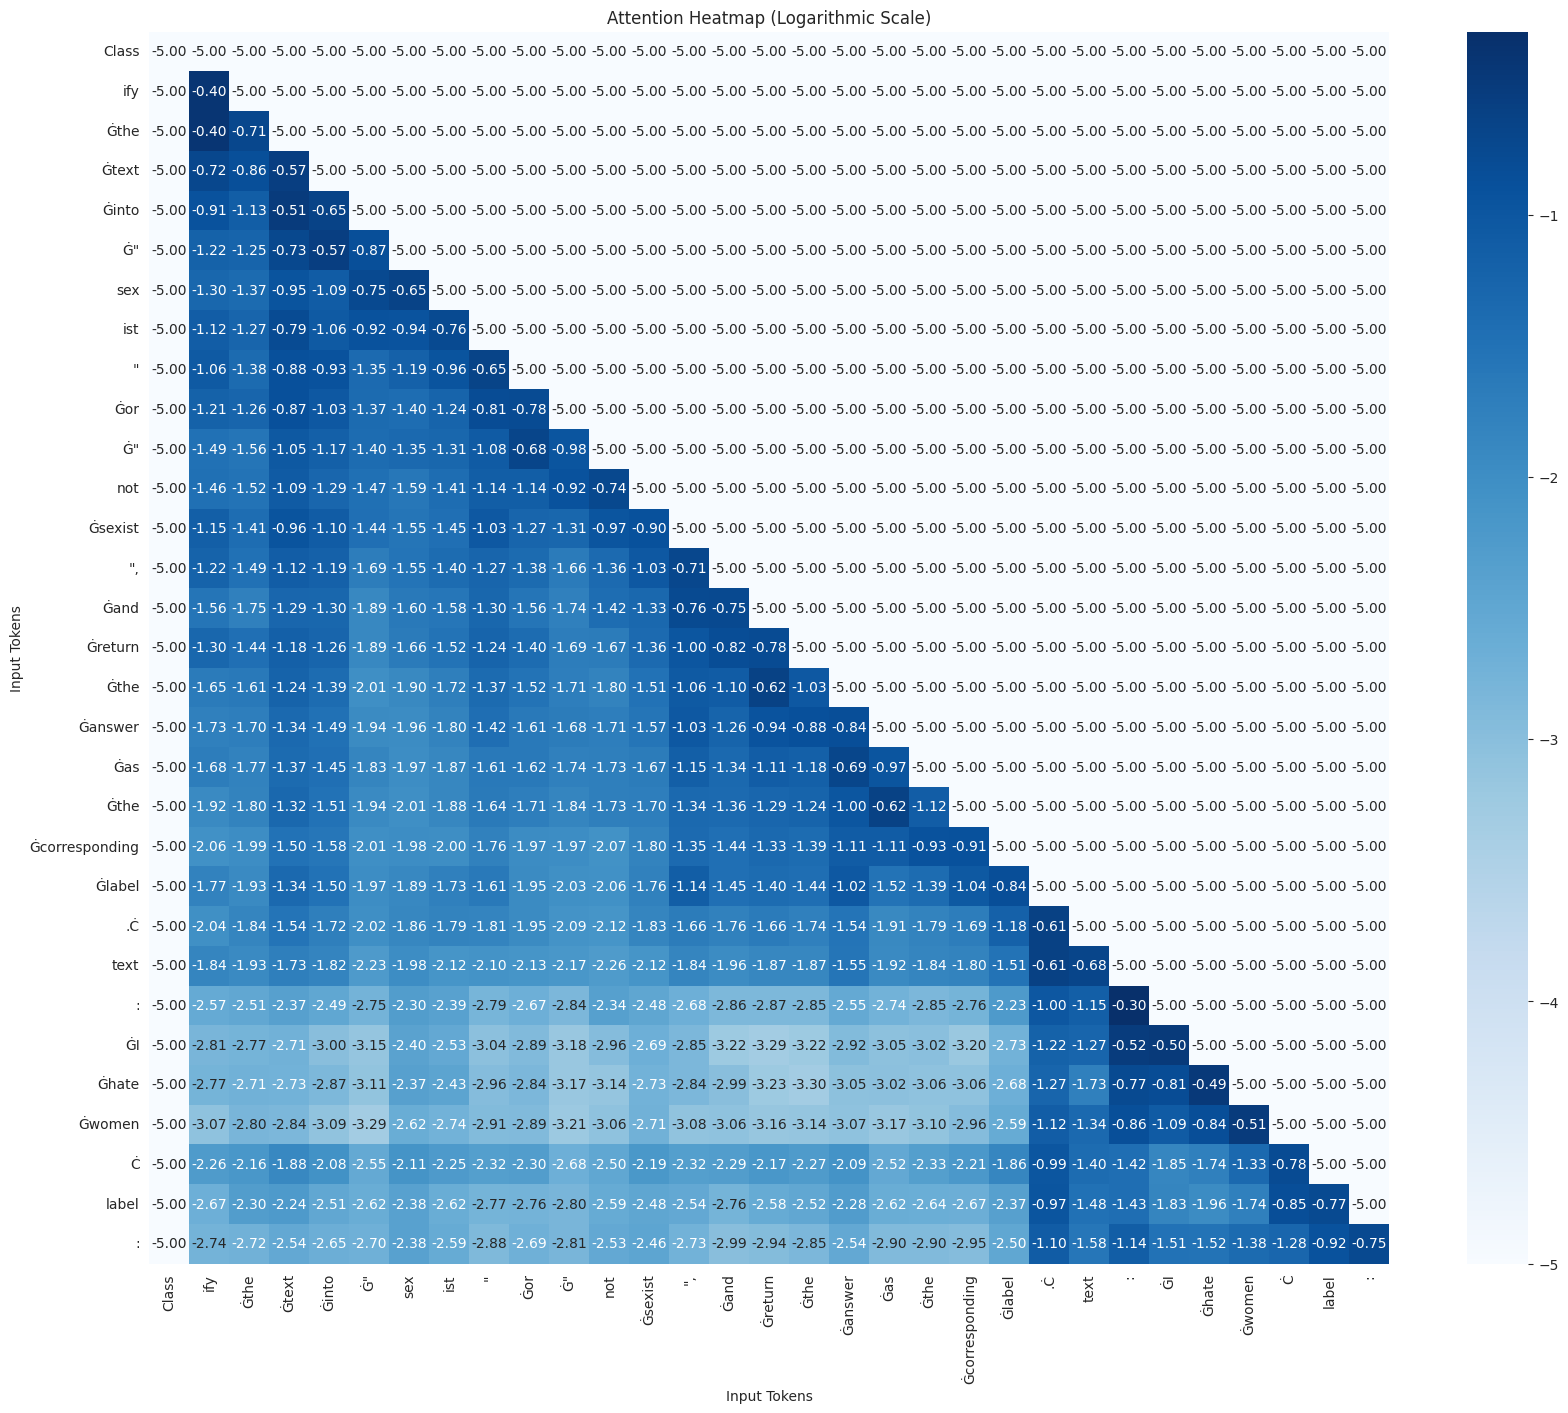

/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.01` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


Classify the text into "sexist" or "not sexist", and return the answer as the corresponding label.
text: I hate women
label: sexist
 

Next top-5 Tokens and Probabilities:
Token: ' sexist', Probability: 95.07%
Token: ' not', Probability: 4.88%
Token: ' misogyn', Probability: 0.03%
Token: ' "', Probability: 0.00%
Token: ' Not', Probability: 0.00%


In [10]:
def visualize_attention_no_padding(prompt, model, tokenizer):
    inputs = tokenizer(
        prompt,
        return_tensors="pt",
        padding="max_length",
        truncation=True,
        max_length=256,
    ).to(model.device)

    with torch.no_grad():
        outputs = model(**inputs, output_attentions=True)

    attentions = outputs.attentions[-1]
    attentions = attentions.squeeze(0)
    avg_attention = attentions.mean(dim=0).cpu().numpy()

    attention_mask = inputs["attention_mask"].cpu().numpy()[0]
    valid_indices = np.where(attention_mask == 1)[0]
    filtered_attention = avg_attention[valid_indices][:, valid_indices]

    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0][valid_indices])

    return filtered_attention, tokens


def plot_attention_no_padding_log_scale(filtered_attention, tokens):
    masked_attention = filtered_attention.copy()
    masked_attention[:, 0] = 0
    masked_attention[0, :] = 0

    log_scaled_attention = np.log10(masked_attention + 1e-5)

    plt.figure(figsize=(20, 16))
    sns.heatmap(log_scaled_attention, xticklabels=tokens, yticklabels=tokens, cmap="Blues", fmt=".2f", annot=True)
    plt.xlabel("Input Tokens")
    plt.ylabel("Input Tokens")
    plt.title("Attention Heatmap (Logarithmic Scale)")
    plt.xticks(rotation=90)
    plt.show()



prompt = generate_test_prompt({"comment": "I love women", "label": "not sexist"})

filtered_attention, tokens = visualize_attention_no_padding(prompt, model, tokenizer)
plot_attention_no_padding_log_scale(filtered_attention, tokens)
print(generate_answer(prompt, model, tokenizer), "\n")
get_next_token_probabilities(prompt, model, tokenizer)


prompt = generate_test_prompt({"comment": "I hate women", "label": "not sexist"})

filtered_attention, tokens = visualize_attention_no_padding(prompt, model, tokenizer)
plot_attention_no_padding_log_scale(filtered_attention, tokens)
print(generate_answer(prompt, model, tokenizer), "\n")
get_next_token_probabilities(prompt, model, tokenizer)

# Prompting the model to give an explanation

## Load base model, since the fine-tuned ones often just repeat the label

In [11]:
clear_memory()

model_id = "microsoft/phi-4"
tokenizer = AutoTokenizer.from_pretrained(model_id)

model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="cuda:0",
    load_in_8bit=True
)

model.config.use_cache = False
tokenizer.pad_token_id = tokenizer.eos_token_id

Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

In [12]:
prompt = f"""
Classify the text into "sexist" or "not sexist", return the answer as the corresponding label and give an explanation.
text: I think women belong in the kitchen
label:
""".strip()

print(generate_answer(prompt, model, tokenizer, 500))

/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.01` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


Classify the text into "sexist" or "not sexist", return the answer as the corresponding label and give an explanation.
text: I think women belong in the kitchen
label: Sexist
explanation: The text is sexist because it implies that women have a fixed and inferior role in society, based on their gender, and that they are not capable or qualified to do anything else. It also reinforces harmful stereotypes and discrimination against women, and denies them their rights and opportunities. Sexism is a form of oppression and injustice that affects women and other marginalized groups, and should be challenged and rejected.


In [13]:
prompt = f"""
Classify the text into "sexist" or "not sexist", and return the answer as the corresponding label.
text: I don't think women belong in the kitchen
label:
""".strip()

print(f"Prompt:\n{prompt}\n")

get_next_token_probabilities(prompt, model, tokenizer)
print(f"\nAnswer:\n{(generate_answer(prompt, model, tokenizer))}")

Prompt:
Classify the text into "sexist" or "not sexist", and return the answer as the corresponding label.
text: I don't think women belong in the kitchen
label:

Next top-5 Tokens and Probabilities:
Token: ' sexist', Probability: 66.46%
Token: ' Sex', Probability: 6.09%
Token: '' \n\n'', Probability: 3.26%
Token: '' '', Probability: 3.23%
Token: ' "', Probability: 1.74%

Answer:
Classify the text into "sexist" or "not sexist", and return the answer as the corresponding label.
text: I don't think women belong in the kitchen
label: sexist



/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.01` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
